<a href="https://colab.research.google.com/github/vadhri/ai-notebook/blob/main/timeseries/ml/rnn_lstm_gru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
import kagglehub

path = kagglehub.dataset_download("abhisheksjha/time-series-air-quality-data-of-india-2010-2023")
print("Path to dataset files:", path)

100%|██████████| 464M/464M [00:12<00:00, 40.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/abhisheksjha/time-series-air-quality-data-of-india-2010-2023/versions/2


In [3]:
path += "/AP001.csv"

In [4]:
aq_dataset = pd.read_csv(path, parse_dates=["From Date", "To Date"], index_col='From Date')

In [5]:
aq_dataset.head()

,To Date,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),...,Temp (degree C),RH (%),WS (m/s),WD (deg),SR (W/mt2),BP (mmHg),VWS (m/s),Xylene (ug/m3),RF (mm),AT (degree C)
From Date,,,,,,,,,,,,,,,,,,,,,
2016-07-01 10:00:00,2016-07-01 11:00:00,10.67,39.0,17.67,39.2,32.33,7.07,6.60,0.48,14.5,...,33.43,71.67,2.30,226.33,123.67,NaN,-0.1,0.1,0.0,23.05
2016-07-01 11:00:00,2016-07-01 12:00:00,2.00,39.0,20.50,41.9,35.80,7.40,NaN,0.49,15.0,...,33.70,70.00,2.50,223.00,186.00,NaN,-0.1,0.1,0.0,NaN
2016-07-01 12:00:00,2016-07-01 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 13:00:00,2016-07-01 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-01 14:00:00,2016-07-01 15:00:00,20.50,50.0,15.40,43.6,32.78,6.35,6.38,0.47,10.5,...,33.57,63.50,1.88,223.00,240.50,NaN,-0.1,0.1,0.0,NaN


In [6]:
aq_dataset.columns

Index(['To Date', 'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)',
       'NOx (ppb)', 'NH3 (ug/m3)', 'SO2 (ug/m3)', 'CO (mg/m3)',
       'Ozone (ug/m3)', 'Benzene (ug/m3)', 'Toluene (ug/m3)',
       'Temp (degree C)', 'RH (%)', 'WS (m/s)', 'WD (deg)', 'SR (W/mt2)',
       'BP (mmHg)', 'VWS (m/s)', 'Xylene (ug/m3)', 'RF (mm)', 'AT (degree C)'],
      dtype='object')

<Axes: xlabel='From Date'>

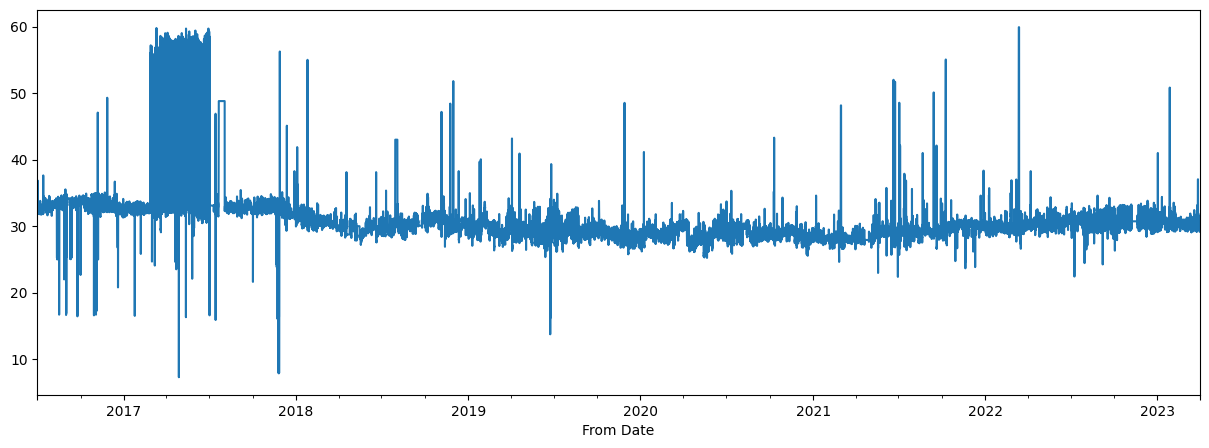

In [7]:
aq_dataset['Temp (degree C)'].ffill().plot(figsize=(15, 5))

In [8]:
# Fill missing values
ts = aq_dataset['Temp (degree C)'].ffill().values.reshape(-1,1)

# Normalize
scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(ts)

# Parameters
seq_length = 7  # use past 7 days to predict next
train_size = int(len(ts_scaled) * 0.8)

train_data = ts_scaled[:train_size]
test_data = ts_scaled[train_size:]

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Convert to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()


#### RNN

In [9]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1, output_size=1):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # take last time step
        return out

model = SimpleRNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)


In [10]:
epochs = 300
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 50 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}')


Epoch 50/300, Loss: 0.003473
Epoch 100/300, Loss: 0.002045
Epoch 150/300, Loss: 0.001995
Epoch 200/300, Loss: 0.001975
Epoch 250/300, Loss: 0.001960
Epoch 300/300, Loss: 0.001953


In [11]:
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train).numpy()
    y_pred_test = model(X_test).numpy()

# Inverse scale
y_pred_test_rescaled = scaler.inverse_transform(y_pred_test)
y_test_rescaled = scaler.inverse_transform(y_test)


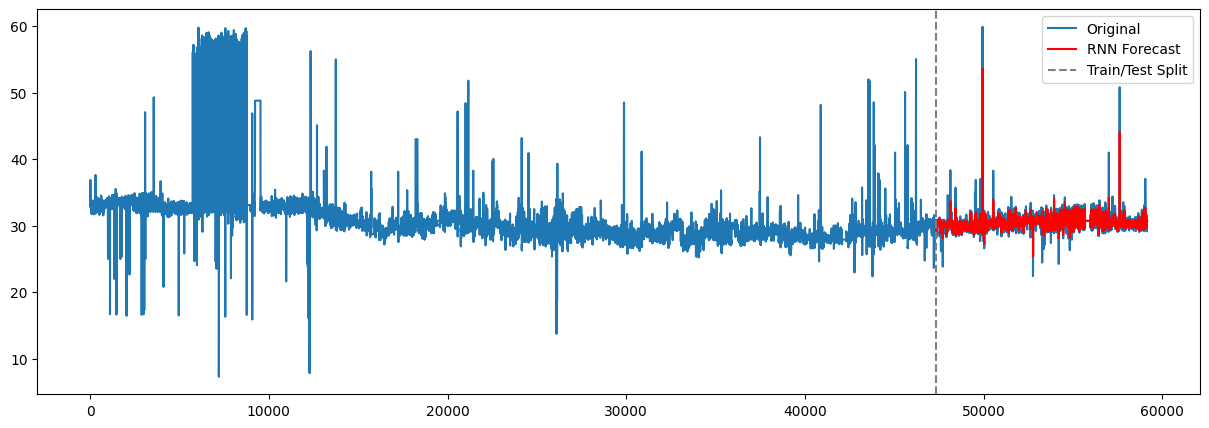

In [12]:
plt.figure(figsize=(15,5))
plt.plot(ts, label='Original')
plt.plot(range(seq_length+train_size, len(ts)), y_pred_test_rescaled, color='red', label='RNN Forecast')
plt.axvline(train_size, color='gray', linestyle='--', label='Train/Test Split')
plt.legend()
plt.show()


In [13]:
mae = mean_absolute_error(y_test_rescaled, y_pred_test_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_test_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, y_pred_test_rescaled)

metrics_df = pd.DataFrame({
    'Metric': ['MAE','MSE','RMSE','R²'],
    'Value':[mae,mse,rmse,r2]
})
print(metrics_df)


  Metric     Value
0    MAE  0.413129
1    MSE  0.700702
2   RMSE  0.837079
3     R²  0.723525


#### LSTM

In [30]:
class LSTMForecast(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=3, output_size=1):
        super(LSTMForecast, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # take output at last time step
        return out

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = LSTMForecast().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


Using device: cuda


In [31]:
# Move data to device
X_train = X_train.to(device)
y_train = y_train.to(device)

# Training loop
epochs = 500
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 50 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}')


Epoch 50/500, Loss: 0.004726
Epoch 100/500, Loss: 0.004677
Epoch 150/500, Loss: 0.002896
Epoch 200/500, Loss: 0.002265
Epoch 250/500, Loss: 0.002117
Epoch 300/500, Loss: 0.002353
Epoch 350/500, Loss: 0.001981
Epoch 400/500, Loss: 0.001941
Epoch 450/500, Loss: 0.001926
Epoch 500/500, Loss: 0.001915


In [34]:
model = model.to('cpu')
X_train = X_train.to('cpu')
y_train = y_train.to('cpu')

model.eval()
with torch.no_grad():
    y_pred_train = model(X_train).numpy()
    y_pred_test = model(X_test).numpy()

# Inverse scale
y_pred_test_rescaled = scaler.inverse_transform(y_pred_test)
y_test_rescaled = scaler.inverse_transform(y_test)


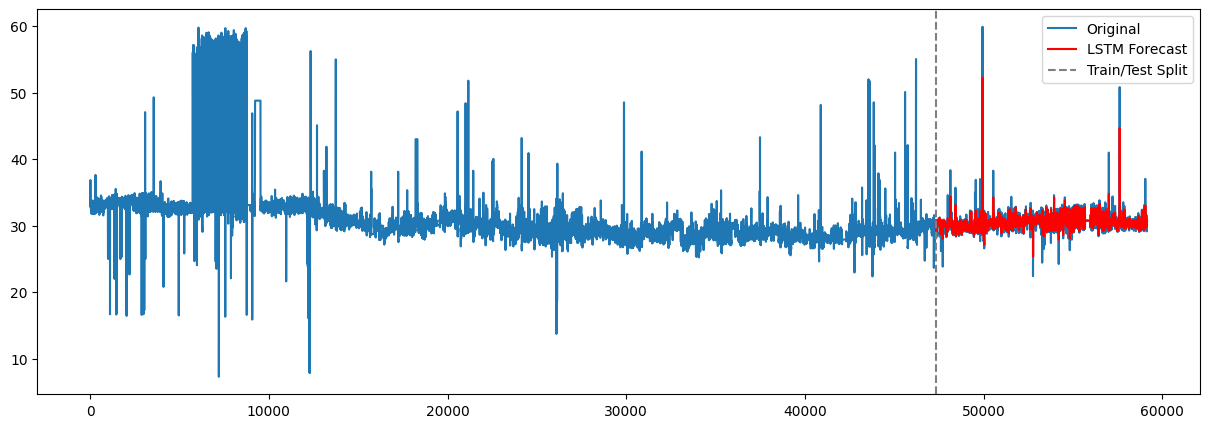

In [35]:
plt.figure(figsize=(15,5))
plt.plot(ts, label='Original')
plt.plot(range(seq_length+train_size, len(ts)), y_pred_test_rescaled, color='red', label='LSTM Forecast')
plt.axvline(train_size, color='gray', linestyle='--', label='Train/Test Split')
plt.legend()
plt.show()


In [36]:
mae = mean_absolute_error(y_test_rescaled, y_pred_test_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_test_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, y_pred_test_rescaled)

metrics_df = pd.DataFrame({
    'Metric': ['MAE','MSE','RMSE','R²'],
    'Value':[mae,mse,rmse,r2]
})
print(metrics_df)


  Metric     Value
0    MAE  0.414179
1    MSE  0.671809
2   RMSE  0.819640
3     R²  0.734925


#### GRU

In [37]:
class GRUForecast(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1, output_size=1):
        super(GRUForecast, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # last time step
        return out


In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GRUForecast().to(device)

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [42]:
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 50 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}')


Epoch 50/1000, Loss: 0.003665
Epoch 100/1000, Loss: 0.003114
Epoch 150/1000, Loss: 0.002348
Epoch 200/1000, Loss: 0.001951
Epoch 250/1000, Loss: 0.001938
Epoch 300/1000, Loss: 0.001932
Epoch 350/1000, Loss: 0.001927
Epoch 400/1000, Loss: 0.001924
Epoch 450/1000, Loss: 0.001921
Epoch 500/1000, Loss: 0.001919
Epoch 550/1000, Loss: 0.001916
Epoch 600/1000, Loss: 0.001914
Epoch 650/1000, Loss: 0.001912
Epoch 700/1000, Loss: 0.001909
Epoch 750/1000, Loss: 0.001905
Epoch 800/1000, Loss: 0.001900
Epoch 850/1000, Loss: 0.001895
Epoch 900/1000, Loss: 0.001890
Epoch 950/1000, Loss: 0.001885
Epoch 1000/1000, Loss: 0.001880


In [45]:
model = model.to('cpu')
X_train = X_train.to('cpu')
X_test = X_test.to('cpu')
y_test = y_test.to('cpu')

model.eval()
with torch.no_grad():
    y_pred_train = model(X_train).numpy()
    y_pred_test = model(X_test).numpy()

# Inverse scale
y_pred_test_rescaled = scaler.inverse_transform(y_pred_test)
y_test_rescaled = scaler.inverse_transform(y_test)


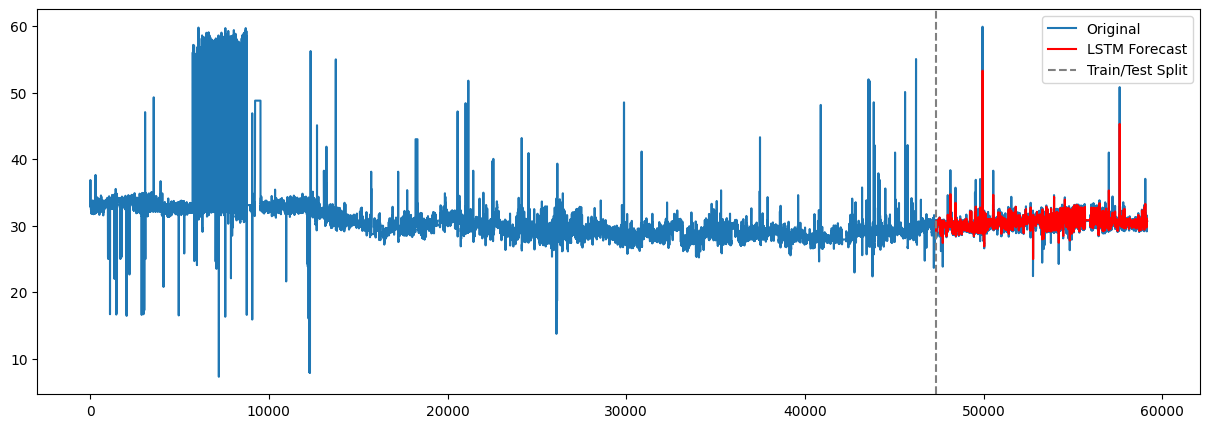

In [47]:
plt.figure(figsize=(15,5))
plt.plot(ts, label='Original')
plt.plot(range(seq_length+train_size, len(ts)), y_pred_test_rescaled, color='red', label='LSTM Forecast')
plt.axvline(train_size, color='gray', linestyle='--', label='Train/Test Split')
plt.legend()
plt.show()


In [46]:
mae = mean_absolute_error(y_test_rescaled, y_pred_test_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_test_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, y_pred_test_rescaled)

metrics_df = pd.DataFrame({
    'Metric': ['MAE','MSE','RMSE','R²'],
    'Value':[mae,mse,rmse,r2]
})
print(metrics_df)


  Metric     Value
0    MAE  0.400363
1    MSE  0.606284
2   RMSE  0.778643
3     R²  0.760779
